# Projeto Final - Ciência dos dados
### Alunos:
- Beatriz Lourenço 
- Fernando Kenji 
- Sophia Kerber
- Pedro H. Menezes

### Pergunta Motivadora:
É possível prever a avaliação de um livro (no ranking do Goodreads) com as seguintes variáveis?
- Inicial do autor
- Número de páginas
- Gênero
- Formato do livro (Capa dura, capa em papel, versão Kindle...)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [2]:
csv = pd.read_csv('book_data.csv')
csv.head()

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
0,Suzanne Collins,Winning will make you famous. Losing means cer...,NaN,Hardcover,9.78044E+12,374 pages,4.33,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...,https://images.gr-assets.com/books/1447303603l...
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.78044E+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.78006E+12,324 pages,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,«È cosa ormai risaputa che a uno scapolo in po...,"Modern Library Classics, USA / CAN",Paperback,9.78068E+12,279 pages,4.25,2453620,54322,Pride and Prejudice,Classics|Fiction|Romance,https://images.gr-assets.com/books/1320399351l...
4,Stephenie Meyer,About three things I was absolutely positive.F...,NaN,Paperback,9.78032E+12,498 pages,3.58,4281268,97991,Twilight,Young Adult|Fantasy|Romance|Paranormal|Vampire...,https://images.gr-assets.com/books/1361039443l...


In [3]:
csv=csv.dropna()
csv.head()

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.78044E+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.78006E+12,324 pages,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,«È cosa ormai risaputa che a uno scapolo in po...,"Modern Library Classics, USA / CAN",Paperback,9.78068E+12,279 pages,4.25,2453620,54322,Pride and Prejudice,Classics|Fiction|Romance,https://images.gr-assets.com/books/1320399351l...
5,Markus Zusak,Trying to make sense of the horrors of World W...,First American Edition (US / CAN),Hardcover,9.78038E+12,552 pages,4.36,1485632,100821,The Book Thief,Historical|Historical Fiction|Fiction|Young Adult,https://images.gr-assets.com/books/1522157426l...
6,C.S. Lewis|Pauline Baynes,"Journeys to the end of the world, fantastic cr...",Reissue Edition,Paperback,9.78007E+12,767 pages,4.25,437829,9439,The Chronicles of Narnia,Fantasy|Classics|Fiction|Young Adult|Childrens,https://images.gr-assets.com/books/1449868701l...


In [4]:
ar = csv['genres'].value_counts()
ar1 = []
iniciais = []
paginas = []
for i in ar.index:
    if i == "":
        ar1.append("")
    else:
        a = i.split('|')
        ar1.append(a[0])
for i in csv['book_authors']:
    iniciais.append(i[0])
for i in csv['book_pages']:
    numero = i.split(' ')
    paginas.append(int(numero[0]))
print(paginas[0:10])
print(iniciais[0:10])
print(ar1[0:10])

[870, 324, 279, 552, 767, 1728, 464, 434, 367, 507]
['J', 'H', 'J', 'M', 'C', 'J', 'E', 'A', 'O', 'C']
['Fantasy', 'Fantasy', 'Fiction', 'Classics', 'Science Fiction', 'Classics', 'Classics', 'Classics', 'Fantasy', 'Romance']


In [5]:
len(csv.index)

3535

In [6]:
ar1=pd.DataFrame({'genero':ar1})
iniciais_ = pd.DataFrame({'iniciais':iniciais})
paginas_ = pd.DataFrame({'paginas':paginas})

In [7]:
csv = csv.join(ar1,how='inner')
csv = csv.join(iniciais_,how='inner')
csv = csv.join(paginas_,how='inner')
csv.head()

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url,genero,iniciais,paginas
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.78044E+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...,Fantasy,H,324
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.78006E+12,324 pages,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...,Fiction,J,279
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,«È cosa ormai risaputa che a uno scapolo in po...,"Modern Library Classics, USA / CAN",Paperback,9.78068E+12,279 pages,4.25,2453620,54322,Pride and Prejudice,Classics|Fiction|Romance,https://images.gr-assets.com/books/1320399351l...,Classics,M,552
5,Markus Zusak,Trying to make sense of the horrors of World W...,First American Edition (US / CAN),Hardcover,9.78038E+12,552 pages,4.36,1485632,100821,The Book Thief,Historical|Historical Fiction|Fiction|Young Adult,https://images.gr-assets.com/books/1522157426l...,Classics,J,1728
6,C.S. Lewis|Pauline Baynes,"Journeys to the end of the world, fantastic cr...",Reissue Edition,Paperback,9.78007E+12,767 pages,4.25,437829,9439,The Chronicles of Narnia,Fantasy|Classics|Fiction|Young Adult|Childrens,https://images.gr-assets.com/books/1449868701l...,Classics,E,464


In [8]:
csv.drop(['book_isbn','book_authors','book_desc','book_edition','book_rating_count','book_review_count','genres','image_url','book_pages'],axis=1,inplace=True)

In [9]:
csv.head()

,book_format,book_rating,book_title,genero,iniciais,paginas
1,Paperback,4.48,Harry Potter and the Order of the Phoenix,Fantasy,H,324
2,Paperback,4.27,To Kill a Mockingbird,Fiction,J,279
3,Paperback,4.25,Pride and Prejudice,Classics,M,552
5,Hardcover,4.36,The Book Thief,Classics,J,1728
6,Paperback,4.25,The Chronicles of Narnia,Classics,E,464


In [10]:
csv['genero'].value_counts()

Fiction                85
Fantasy                49
Classics               39
Young Adult            35
Romance                28
Nonfiction             24
Science Fiction        15
Philosophy             15
Mystery                14
Sequential Art         13
History                12
Historical             12
Thriller                8
Short Stories           8
European Literature     7
Biography               6
Poetry                  6
Media Tie In            5
Horror                  5
Childrens               5
Religion                5
Paranormal              5
Business                4
Novels                  3
Cultural                3
Spirituality            2
Contemporary            2
Erotica                 2
Reference               2
Writing                 2
Science                 2
Animals                 2
Art                     2
Computer Science        2
Plays                   2
Psychology              2
New Adult               1
Leadership              1
Autobiograph

In [11]:
csv.shape

(449, 6)

In [12]:
csv.loc[(csv['book_rating']>= 3.5)]

,book_format,book_rating,book_title,genero,iniciais,paginas
1,Paperback,4.48,Harry Potter and the Order of the Phoenix,Fantasy,H,324
2,Paperback,4.27,To Kill a Mockingbird,Fiction,J,279
3,Paperback,4.25,Pride and Prejudice,Classics,M,552
5,Hardcover,4.36,The Book Thief,Classics,J,1728
6,Paperback,4.25,The Chronicles of Narnia,Classics,E,464
9,Mass Market Paperback,4.59,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,Romance,C,507
13,Paperback,3.84,Wuthering Heights,Media Tie In,O,324
15,Hardcover,4.09,Memoirs of a Geisha,Young Adult,J,112
17,Paperback,4.06,The Picture of Dorian Gray,Mystery,W,398
20,Paperback,4.11,Jane Eyre,Young Adult,M,273


In [13]:
y = csv['book_rating'].values
num = csv[['paginas']]
qual = csv[['book_format','genero','iniciais']]

In [14]:
qual.head()

,book_format,genero,iniciais
1,Paperback,Fantasy,H
2,Paperback,Fiction,J
3,Paperback,Classics,M
5,Hardcover,Classics,J
6,Paperback,Classics,E


In [15]:
encoder = OneHotEncoder()
capa_encoded = encoder.fit_transform(qual)


In [16]:
x_num = num.values

In [17]:
x_encoded = capa_encoded.toarray()

In [18]:
X = np.concatenate((x_num,x_encoded), axis=1)

In [19]:
X[0]

array([324.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

In [20]:
y[0]

4.48

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing,utils, metrics
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()  
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
for i in range(len(y_pred)):
    if y_pred[i]>5:
        y_pred[i]=5
    if y_pred[i]<0:
        y_pred[i]=0
        
df = pd.DataFrame({'Atual': y_test.flatten(), 'Predito': y_pred.flatten()})
df.head()

,Atual,Predito
0,4.10,4.133494
1,4.27,4.053161
2,3.57,4.040311
3,4.24,4.318508
4,4.09,4.188282


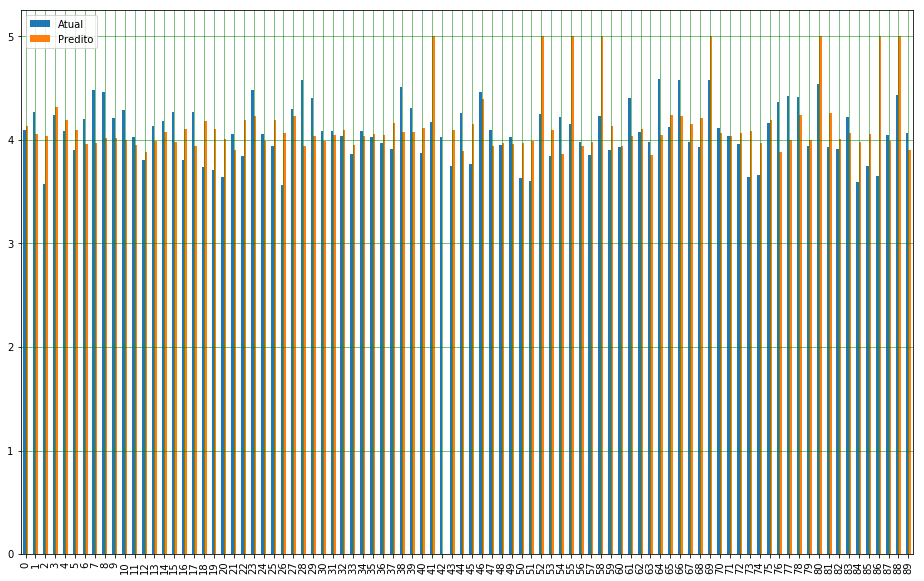

In [28]:
df1 = df
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [30]:
print("O R² é " + str(metrics.r2_score(df['Atual'],df['Predito'])))

O R² é -3.309921176186159
